In [1]:
import sys, time
import torch
import numpy as np
import matplotlib.pyplot as plt
import corner
import arviz as az

sys.path.append('..')

from gdiff.data import ImageDataset, get_colored_noise_2d
from gdiff.model import load_model
import gdiff.hmc_utils as iut
from gdiff.utils import ssim, psnr, plot_power_spectrum, plot_list_of_images

/mnt/sw/nix/store/5zccdpbxzjvkky2asjixbxz4g7kgg4lh-python-3.9.18-view/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/5zccdpbxzjvkky2asjixbxz4g7kgg4lh-python-3.9.18-view/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/5zccdpbxzjvkky2asjixbxz4g7kgg4lh-python-3.9.18-view/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/5zccdpbxzjvkky2asjixbxz4g7kgg4lh-python-3.9.18-view/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'n

In [2]:
#
# PARAMETERS
#

# Dataset and sample
dataset_name = "CBSD68" # Choices among "imagenet_train", "imagenet_val", "cbsd68", "mcmaster", "kodak24"
dataset = ImageDataset(dataset_name)
sample_id = 13 # np.random.randint(len(dataset))

# Noise
phi_true = -0.4     # Spectral index -> between -1 and 1 (\varphi in the paper)
sigma_true = 0.1    # Noise level

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
diffusion_steps = 5000 # Number of diffusion steps: 5000 or 10000
model = load_model(diffusion_steps=diffusion_steps, device=device)

# Inference
num_chains = 4      # Number of HMC chains
n_it_gibbs = 50     # Number of Gibbs iterations after burn-in
n_it_burnin = 25    # Number of burn-in iterations

Time step corresponding to noise level 0.100: 134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/mnt/home/bregaldosaintblancard/Projects/Diffusion4Dust/Gibbs-Diffusion/gdiff/utils.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/mnt/home/bregaldosaintblancard/Projects/Diffusion4Dust/Gibbs-Diffusion/gdiff/utils.py:164: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


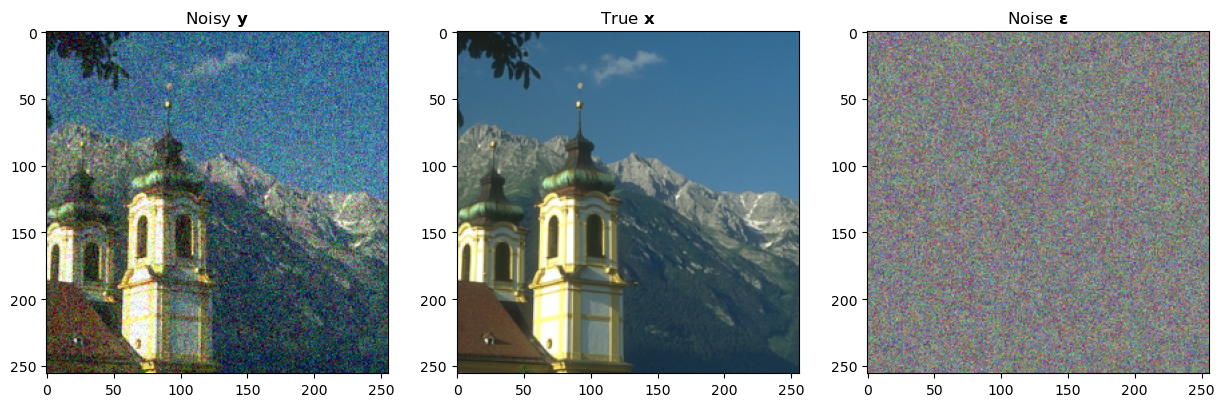

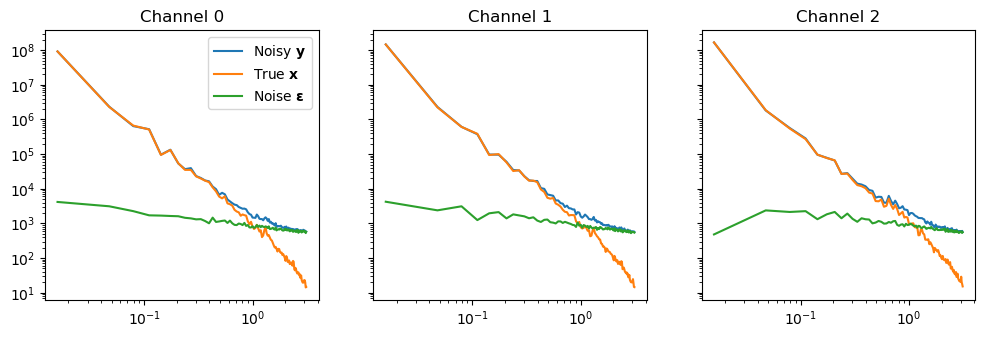

In [3]:
#
# MAKE TEST NOISY IMAGE
#

# Get clean image
x = dataset[sample_id][0].to(device).unsqueeze(0)

# Our DDPM has discrete timestepping -> we get the time step closest to the chosen noise level
sigma_true_timestep, sigma_true = model.get_closest_timestep(torch.tensor([sigma_true]), ret_sigma=True)
alpha_bar_t = model.alpha_bar_t[sigma_true_timestep.cpu()].reshape(-1, 1, 1, 1).to(device)
print(f"Time step corresponding to noise level {sigma_true.item():.3f}: {sigma_true_timestep.item()}")

# We generate colored noise with the correct spectral index and make the noisy image y
eps = torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t) * get_colored_noise_2d(x.shape, phi_true).to(device)
y = x + eps # Noisy image
yt = torch.sqrt(alpha_bar_t) * y # Noisy image normalized for the diffusion model

# Plot
data = [y[0], x[0], eps[0]]
labels = [r"Noisy $\mathbf{y}$", r"True $\mathbf{x}$", r"Noise $\mathbf{\varepsilon}$"]
plot_list_of_images([y[0], x[0], eps[0] + 0.5], labels) # We add 0.5 to eps to center it on the colorbar
plot_power_spectrum([y[0], x[0], eps[0]], labels, figsize=(12, 3.5))

In [4]:
#
# DENOISING
#

# Non-blind denoising (for reference)
print("Denoising in non-blind setting...")
t0 = time.time()
x_hat_nonblind = model.denoise_samples_batch_time(yt,
                                                  sigma_true_timestep.unsqueeze(0),
                                                  phi_ps=phi_true)
t1 = time.time()
print(f"Non-blind denoising took {t1-t0:.2f} seconds")

# Blind denoising with GDiff
print("Denoising in blind setting (GDiff)...")
t0 = time.time()
phi_hat_blind, x_hat_blind = model.blind_denoising(y, yt,
                                                   num_chains_per_sample=num_chains,
                                                   n_it_gibbs=n_it_gibbs,
                                                   n_it_burnin=n_it_burnin)
t1 = time.time()
print(f"Blind denoising took {t1-t0:.2f} seconds")

# Denoised posterior mean estimate
x_hat_blind_pmean = x_hat_blind[:, n_it_burnin:].mean(dim=(0, 1))

Denoising in non-blind setting...
Non-blind denoising took 4.74 seconds
Denoising in blind setting (GDiff)...


  0%|          | 0/75 [00:00<?, ?it/s]

Adapting step size using 300 iterations
Step size fixed to :  tensor([0.0229, 0.0198, 0.0242, 0.0249], device='cuda:0')


100%|██████████| 75/75 [10:56<00:00,  8.75s/it]

Blind denoising took 656.49 seconds


/tmp/ipykernel_2724820/1484985891.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


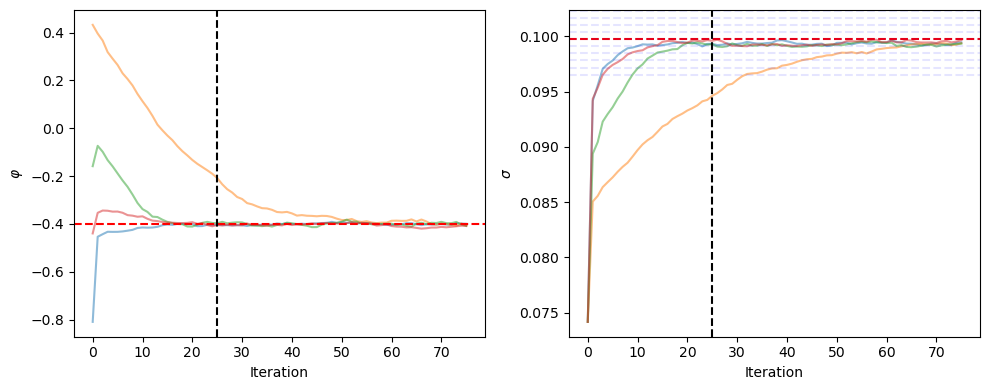

In [5]:
#
# TRACE PLOTS FOR SIGMA AND PHI
#

# Trace plots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for i in range(num_chains):
    axs[0].plot(iut.unnormalize_phi(phi_hat_blind[i, :, 0]).cpu().numpy(), alpha=0.5)
    axs[1].plot(phi_hat_blind[i, :, 1].cpu().numpy(), alpha=0.5)
axs[0].set_ylabel(r'$\varphi$')
axs[1].set_ylabel(r'$\sigma$')
axs[0].set_xlabel('Iteration')
axs[1].set_xlabel('Iteration')
axs[0].axhline(phi_true, color='r', linestyle='--')
axs[1].axhline(sigma_true, color='r', linestyle='--')
axs[0].axvline(n_it_burnin, color='k', linestyle='--')
axs[1].axvline(n_it_burnin, color='k', linestyle='--')
timesteps_to_plot = torch.arange(sigma_true_timestep.item() - 5, sigma_true_timestep.item() + 5)
sigmas_to_plot = torch.sqrt((1-model.alpha_bar_t[timesteps_to_plot])/model.alpha_bar_t[timesteps_to_plot]).squeeze().cpu().numpy()
for sigma_to_plot in sigmas_to_plot: # Adding sigma grid of the diffusion model
    axs[1].axhline(sigma_to_plot, color='b', linestyle='--', alpha=0.1)
fig.tight_layout()
fig.show()

/mnt/sw/nix/store/5zccdpbxzjvkky2asjixbxz4g7kgg4lh-python-3.9.18-view/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


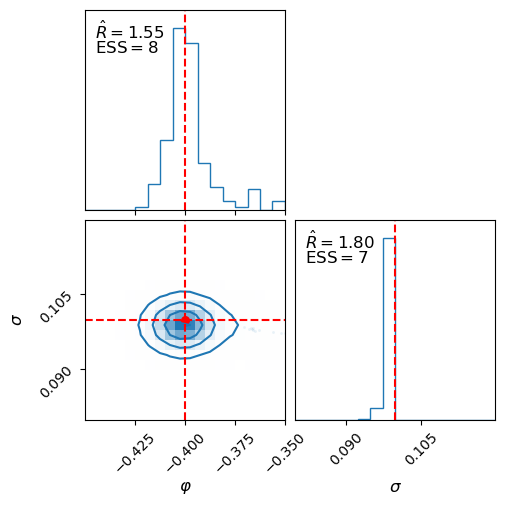

In [6]:
#
# CORNER PLOT FOR PHI AND SIGMA
#

# Compute ESS and Rhat for diagnostics
az_infdata = az.convert_to_inference_data(phi_hat_blind[:, n_it_burnin:, :].cpu().numpy())
ess = az.ess(az_infdata)['x'].values
rhat = az.rhat(az_infdata)['x'].values


tensor_params_all = torch.cat((iut.unnormalize_phi(phi_hat_blind[:, n_it_burnin:, :1]),
                               phi_hat_blind[:, n_it_burnin:, 1:]), dim=-1).cpu().numpy().reshape(-1, 2)
params_true = np.array([phi_true, sigma_true.item()])

labels = [r'$\varphi$', r'$\sigma$']
fig = corner.corner(tensor_params_all,
                    labels=labels,
                    show_titles=False,
                    color='C0',
                    hist_kwargs={'color': 'C0', 'density': True},
                    smooth=1.5,
                    hist_bin_factor=0.8,
                    label_kwargs={'fontsize': 12},
                    max_n_ticks=4,
                    range=[(params_true[0] - 0.05, params_true[0] + 0.05), (params_true[1] - 0.02, params_true[1] + 0.02)])
axes = fig.get_axes()
for i in range(2):
    for j in range(2):
        if i > j:
            axes[i*2+j].axvline(params_true[j], color='r', linestyle='--')
            axes[i*2+j].axhline(params_true[i], color='r', linestyle='--')
            axes[i*2+j].scatter(params_true[j], params_true[i], color='r', s=30)
        if i == j:
            axes[i*2+j].axvline(params_true[j], color='r', linestyle='--')
            axes[i*2+j].text(0.05, 0.95, r'$\hat{{R}} = {:.2f}$'.format(rhat[j]), transform=axes[i*2+j].transAxes, fontsize=12, verticalalignment='top')
            axes[i*2+j].text(0.05, 0.85, r'$\text{{ESS}} = {:.0f}$'.format(ess[j]), transform=axes[i*2+j].transAxes, fontsize=12, verticalalignment='top')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/mnt/home/bregaldosaintblancard/Projects/Diffusion4Dust/Gibbs-Diffusion/gdiff/utils.py:190: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/mnt/home/bregaldosaintblancard/Projects/Diffusion4Dust/Gibbs-Diffusion/gdiff/utils.py:212: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


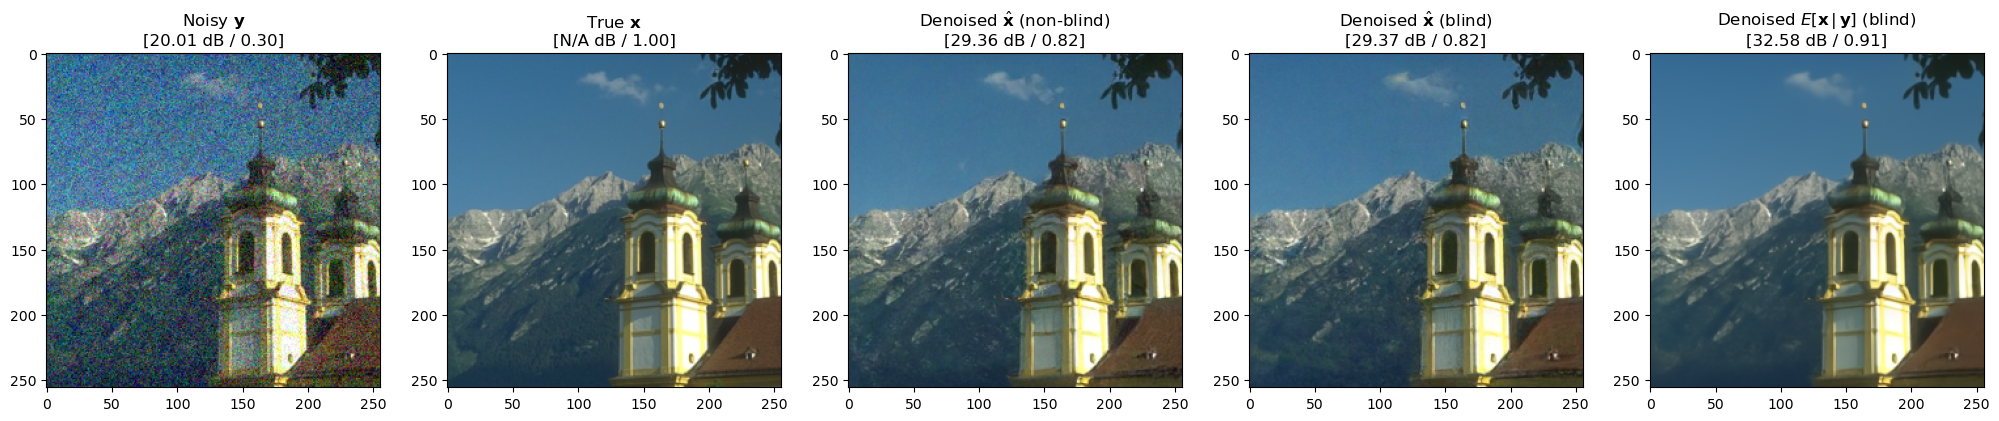

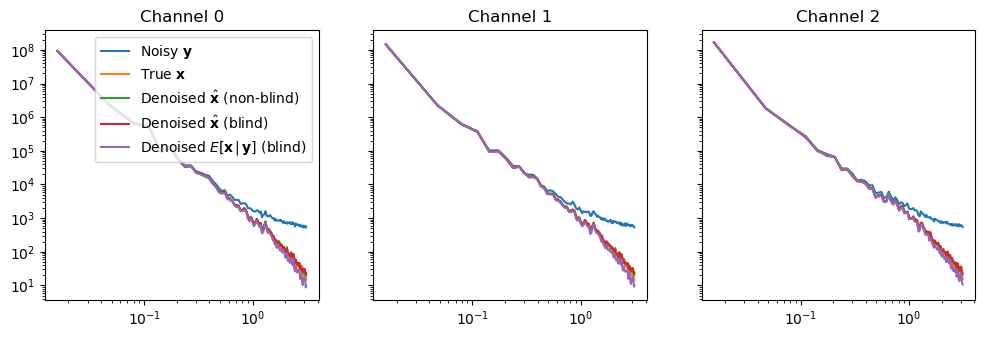

In [7]:
#
# Plot of a reconstruction
#

data = [y[0],
        x[0],
        x_hat_nonblind[0],
        x_hat_blind[0, -1],
        x_hat_blind_pmean]
labels_base = [r"Noisy $\mathbf{y}$",
          r"True $\mathbf{x}$",
          r"Denoised $\hat{\mathbf{x}}$ (non-blind)",
          r"Denoised $\hat{\mathbf{x}}$ (blind)",
          r"Denoised $E[\mathbf{x}\,|\,\mathbf{y}]$ (blind)"]
labels = [labels_base[0] + "\n" f"[{psnr(x[0], y[0]).item():.2f} dB / {ssim(x[0], y[0]).item():.2f}]",
          labels_base[1] + "\n" f"[N/A dB / {ssim(x[0], x[0]).item():.2f}]",
          labels_base[2] + "\n" f"[{psnr(x[0], x_hat_nonblind[0]).item():.2f} dB / {ssim(x[0], x_hat_nonblind[0]).item():.2f}]",
          labels_base[3] + "\n" f"[{psnr(x[0], x_hat_blind[0, -1]).item():.2f} dB / {ssim(x[0], x_hat_blind[0, -1]).item():.2f}]",
          labels_base[4] + "\n" f"[{psnr(x[0], x_hat_blind_pmean).item():.2f} dB / {ssim(x[0], x_hat_blind_pmean).item():.2f}]"]
plot_list_of_images(data, labels)
plot_power_spectrum(data, labels_base, figsize=(12, 3.5))